In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib

In [3]:
def generate_noise(mu, sigma, size):
    return np.random.normal(mu, sigma, size)

def plot_graph(arr, name):
    plt.plot(arr)
    plt.ylabel(name)
    plt.xlabel('Time')
    plt.show()
    
def add_point(scat, new_point, c='k'):
    old_off = scat.get_offsets()
    new_off = np.concatenate([old_off,np.array(new_point, ndmin=2)])
    old_c = scat.get_facecolors()
    new_c = np.concatenate([old_c, np.array(matplotlib.colors.to_rgba(c), ndmin=2)])

    scat.set_offsets(new_off)
    scat.set_facecolors(new_c)

    scat.axes.figure.canvas.draw_idle()

In [4]:
A = 0.2

num_of_data_pts = 100

time = np.linspace(0, num_of_data_pts - 1, num=num_of_data_pts)

model_v_func = lambda t: A * t

model_v = model_v_func(time)
model_integral_v = np.array(model_v)

temp_y = 0

for idx, y in enumerate(model_v):
    temp_y = temp_y + y
    model_integral_v[idx] = temp_y

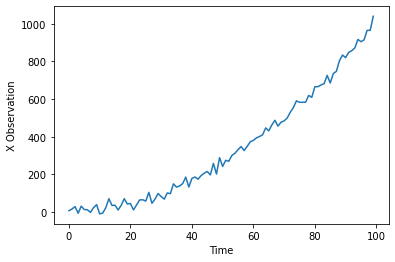

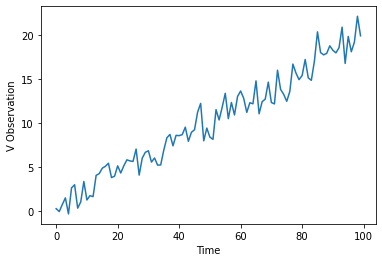

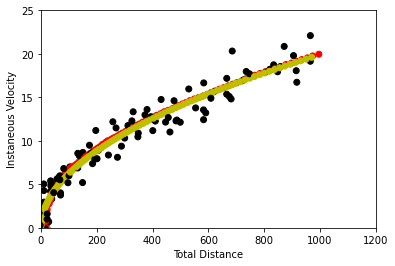

In [9]:
x_observations = model_integral_v + generate_noise(0, 20, num_of_data_pts) + 5
v_observations = model_v + generate_noise(0, 1.3, num_of_data_pts)

plot_graph(x_observations, "X Observation")
plot_graph(v_observations, "V Observation")

z = np.c_[x_observations, v_observations]

# Initial Conditions
a = 0.2  # Acceleration
v = 0
t = 1  # Difference in time

# Process / Estimation Errors
error_est_x = 5
error_est_v = 1

# Observation Errors
error_obs_x = 2  # Uncertainty in the measurement
error_obs_v = 1

def prediction2d(x, v, t, a):
    A = np.array([[1, t],
                  [0, 1]])
    X = np.array([[x],
                  [v]])
    B = np.array([[0.5 * t ** 2],
                  [t]])
    X_prime = A.dot(X) + B.dot(a)
    return X_prime


def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))


# Initial Estimation Covariance Matrix
P = covariance2d(error_est_x, error_est_v)
A = np.array([[1, t],
              [0, 1]])

# Initial State Matrix
X = np.array([[z[0][0]],
              [v]])
n = len(z[0])

fig, ax = plt.subplots()
scat = ax.scatter([],[],cmap=matplotlib.cm.spring, c=[])
fig.canvas.draw()  # if running all the code in the same cell, this is required for it to work, not sure why
ax.set_xlim(0,1200)
ax.set_ylim(0,25)
ax.set_xlabel("Total Distance")
ax.set_ylabel("Instaneous Velocity")

for idx, data in enumerate(z[1:]):
    X = prediction2d(X[0][0], X[1][0], t, a)
    # To simplify the problem, professor
    # set off-diagonal terms to 0.
    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    # Calculating the Kalman Gain
    H = np.identity(n)
    R = covariance2d(error_obs_x, error_obs_v)
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H).dot(inv(S))

    # Reshape the new data into the measurement space.
    Y = H.dot(data).reshape(n, -1)

    # Update the State Matrix
    # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
    X = X + K.dot(Y - H.dot(X))

    # Update Process Covariance Matrix
    P = (np.identity(len(K)) - K.dot(H)).dot(P)
    
    add_point(scat, [X[0][0],X[1][0]], 'r')
    add_point(scat, [x_observations[idx], v_observations[idx]])
    add_point(scat, [model_integral_v[idx], model_v[idx]], 'y')